<a href="https://colab.research.google.com/github/Soobian/deeplearning-project-f1/blob/simple-model/deep_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras import mixed_precision
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive

from tensorflow.keras.applications import EfficientNetB0



# Model 1: EfficientNetB0 trained with in-game data


## Set model parameters

**Parameters**
*   Input size: 224 x 224 px
*   Model class: EfficientNetB0
*   Batch size: 32
*   Epochs: 500





In [2]:
# Set model constants
INPUT_SIZE = (224, 224)
MODEL_CLASS = EfficientNetB0
BATCH_SIZE = 16
EPOCHS = 500


## Set up data

*   Use only in-game data for training, validation and testing


In [3]:
# Connect to Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# Path of datasets
train_dir = '/content/drive/MyDrive/Colab Notebooks/DatasetClassification/f1cars/Game_Dataset/train'
val_dir = '/content/drive/MyDrive/Colab Notebooks/DatasetClassification/f1cars/Game_Dataset/val'
test_dir = '/content/drive/MyDrive/Colab Notebooks/DatasetClassification/f1cars/Game_Dataset/test'


In [5]:
# Get dataset from directory
def get_data_from_dir(dir, batch_size=BATCH_SIZE, input_size=INPUT_SIZE):
  data = keras.utils.image_dataset_from_directory(
        dir,
        labels="inferred",
        label_mode="categorical",
        color_mode="rgb",
        batch_size=batch_size,
        image_size=(input_size[0], input_size[1]),
        shuffle=True
    )

  return data


In [6]:
# Get datasets and create a mixed dataset
def prepare_data(input_size=INPUT_SIZE):
    # Training data
    train_data = get_data_from_dir(train_dir)

    # Validation data
    val_data = get_data_from_dir(val_dir)

    # Test data
    test_data = get_data_from_dir(test_dir)

    # Prefetch to optimize performance
    train_data = train_data.prefetch(tf.data.AUTOTUNE)
    val_data = val_data.prefetch(tf.data.AUTOTUNE)
    test_data = test_data.prefetch(tf.data.AUTOTUNE)

    return train_data, val_data, test_data


In [7]:
# Prepare data with the specified input size and mixing ratio
print(f"Preparing data for EfficientNetB0 with input size {INPUT_SIZE}")
train_data, val_data, test_data = prepare_data()


Preparing data for EfficientNetB0 with input size (224, 224)
Found 6288 files belonging to 10 classes.
Found 790 files belonging to 10 classes.
Found 780 files belonging to 10 classes.


## Show dataset examples

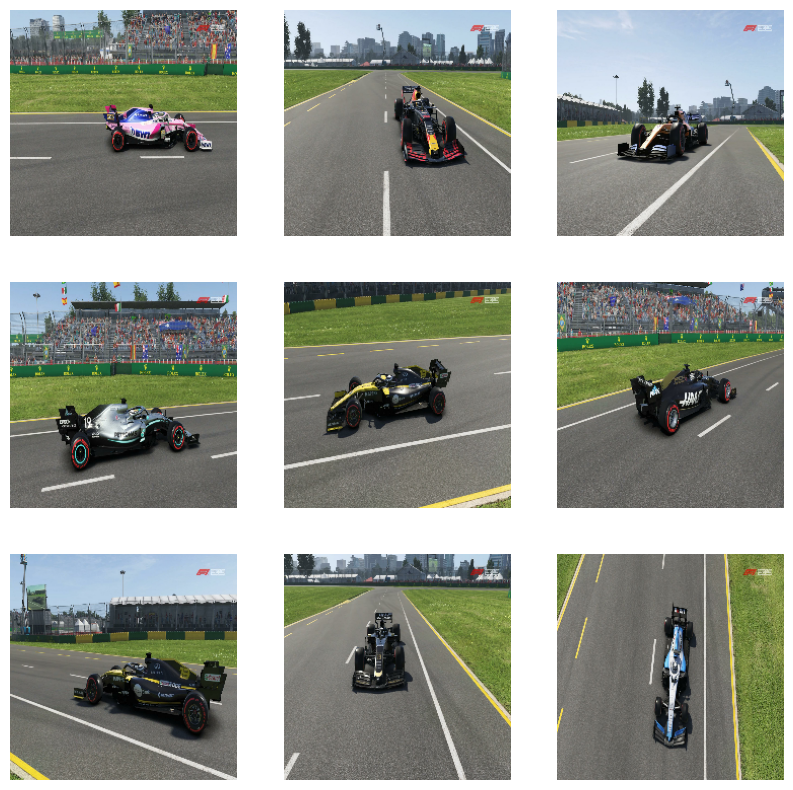

In [8]:
# Show image from dataset classes
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        pred_class = np.argmax(labels[i])
        plt.axis("off")


## Training the model

### Creating the model

*   Freeze the base model
*   Single dense layer
*   Learning rate: 0.005



In [9]:
LEARNING_RATE = 0.005

In [10]:
def create_model(base_model_class=MODEL_CLASS, input_size=INPUT_SIZE):
    input_layer = Input(shape=(input_size[0], input_size[1], 3), name="input_layer")
    base_model = base_model_class(include_top=False, weights='imagenet')

    # Freeze the base model
    base_model.trainable = False

    # Add base model
    x = base_model(input_layer, training=False)
    x = GlobalAveragePooling2D()(x)

    # Single dense layer
    x = Dense(64, activation='relu')(x)

    # Output layer with 10 classes
    output = Dense(10, activation='softmax', dtype=tf.float32)(x)

    # Create model
    model = keras.Model(inputs=input_layer, outputs=output)

    return model


In [11]:
model = create_model()

print(f"Model created for {MODEL_CLASS} with input size {INPUT_SIZE}.")

# Compile the model using SGD optimizer
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Model created for <function EfficientNetB0 at 0x7ea3f32068c0> with input size (224, 224).


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          81,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,132,205 (15.76 MB)

 Trainable params: 82,634 (322.79 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

### Plot the training data

In [12]:
# Plot the training and validation data
def plot_history(history):
  # Extract accuracy and loss from the history object
  train_acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Plot accuracy
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(train_acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.title(f'Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  # Plot loss
  plt.subplot(1, 2, 2)
  plt.plot(train_loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.title(f'Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()


In [13]:
def show_results(history):
  # Plot the training and validation data
  plot_history(history)

  # Get the final training and validation loss and accuracy
  train_loss = history.history['loss'][-1]
  train_accuracy = history.history['accuracy'][-1]
  val_loss = history.history['val_loss'][-1]
  val_accuracy = history.history['val_accuracy'][-1]

  print(f"Training Loss: {train_loss:.4f}")
  print(f"Training Accuracy: {train_accuracy:.4f}")
  print(f"Validation Loss: {val_loss:.4f}")
  print(f"Validation Accuracy: {val_accuracy:.4f}")


### Train model

In [14]:
MODEL_SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/'


In [15]:
# Calculate steps per epoch
def calculate_steps(data, batch_size=BATCH_SIZE):
    return (int)(len(data) / batch_size)

steps_per_epoch = calculate_steps(train_data)
validation_steps = calculate_steps(val_data)


In [16]:
from datetime import datetime

# Save the model with a timestamped filename
def save_model(model, path=MODEL_SAVE_PATH):
  timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
  model_save_path = f"{MODEL_SAVE_PATH}model_{timestamp}.keras"
  model.save(model_save_path)


In [17]:
def train_model(model, train_data, val_data, batch_size=BATCH_SIZE, epochs=EPOCHS):
  # Train the model and capture the training history
  history = model.fit(
    train_data,
    validation_data=val_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
  )

  save_model(model)

  show_results(history)


In [18]:
train_model(model, train_data, val_data)


Epoch 1/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 193s 7s/step - accuracy: 0.0972 - loss: 2.4095 - val_accuracy: 0.1875 - val_loss: 2.2150
Epoch 2/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 122s 5s/step - accuracy: 0.1910 - loss: 2.2044 - val_accuracy: 0.1667 - val_loss: 2.2208
Epoch 3/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 142s 6s/step - accuracy: 0.2229 - loss: 2.1592 - val_accuracy: 0.2708 - val_loss: 2.1098
Epoch 4/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 146s 6s/step - accuracy: 0.2995 - loss: 2.1060 - val_accuracy: 0.3125 - val_loss: 2.0480
Epoch 5/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 145s 6s/step - accuracy: 0.3029 - loss: 2.0801 - val_accuracy: 0.2083 - val_loss: 2.0149
Epoch 6/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 143s 6s/step - accuracy: 0.3859 - loss: 1.9680 - val_accuracy: 0.4167 - val_loss: 1.8914
Epoch 7/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 144s 6s/step - accuracy: 0.4125 - loss: 1.9247 - val_accuracy: 0.4792 - val_loss: 1.8611
Epoch 8/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 140s 6s/step - accuracy: 0.4640 - loss: 1.8761 - val_accuracy: 0.

KeyboardInterrupt: 

# Model 2: EfficientNetB0 trained with in-game data with adaptable learning rate


## Set model parameters

**Parameters**
*   Input size: 224 x 224 px
*   Model class: EfficientNetB0
*   Batch size: 32
*   Epochs: 500

In [6]:
# Set model constants
INPUT_SIZE = (224, 224)
MODEL_CLASS = EfficientNetB0
BATCH_SIZE = 16
EPOCHS = 500


## Set up data

*   Use only in-game data for training, validation and testing


In [7]:
# Connect to Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [8]:
# Path of datasets
train_dir = '/content/drive/MyDrive/Colab Notebooks/DatasetClassification/f1cars/Game_Dataset/train'
val_dir = '/content/drive/MyDrive/Colab Notebooks/DatasetClassification/f1cars/Game_Dataset/val'
test_dir = '/content/drive/MyDrive/Colab Notebooks/DatasetClassification/f1cars/Game_Dataset/test'


In [9]:
# Get dataset from directory
def get_data_from_dir(dir, batch_size=BATCH_SIZE, input_size=INPUT_SIZE):
  data = keras.utils.image_dataset_from_directory(
        dir,
        labels="inferred",
        label_mode="categorical",
        color_mode="rgb",
        batch_size=batch_size,
        image_size=(input_size[0], input_size[1]),
        shuffle=True
    )

  return data


In [10]:
# Get datasets and create a mixed dataset
def prepare_data(input_size=INPUT_SIZE):
    # Training data
    train_data = get_data_from_dir(train_dir)

    # Validation data
    val_data = get_data_from_dir(val_dir)

    # Test data
    test_data = get_data_from_dir(test_dir)

    # Prefetch to optimize performance
    train_data = train_data.prefetch(tf.data.AUTOTUNE)
    val_data = val_data.prefetch(tf.data.AUTOTUNE)
    test_data = test_data.prefetch(tf.data.AUTOTUNE)

    return train_data, val_data, test_data


In [11]:
# Prepare data with the specified input size and mixing ratio
print(f"Preparing data for EfficientNetB0 with input size {INPUT_SIZE}")
train_data, val_data, test_data = prepare_data()


Preparing data for EfficientNetB0 with input size (224, 224)
Found 6288 files belonging to 10 classes.
Found 790 files belonging to 10 classes.
Found 780 files belonging to 10 classes.


## Training the model

### Creating the model

*   Freeze the base model
*   Single dense layer
*   Learning rate: 0.005 (ExponentialDecay)

In [12]:
def create_model(base_model_class=MODEL_CLASS, input_size=INPUT_SIZE):
    input_layer = Input(shape=(input_size[0], input_size[1], 3), name="input_layer")
    base_model = base_model_class(include_top=False, weights='imagenet')

    # Freeze the base model
    # base_model.trainable = False

    # Freeze the base model's first 200 layers
    base_model.trainable = True
    for layer in base_model.layers[:200]:
      layer.trainable = False

    # Add base model
    x = base_model(input_layer, training=False)
    x = GlobalAveragePooling2D()(x)

    # Single dense layer
    x = Dense(64, activation='relu')(x)

    # Output layer with 10 classes
    output = Dense(10, activation='softmax', dtype=tf.float32)(x)

    # Create model
    model = keras.Model(inputs=input_layer, outputs=output)

    return model


In [13]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.005,
    decay_steps=2000,
    decay_rate=0.96
)


In [14]:
model = create_model()

print(f"Model created for {MODEL_CLASS} with input size {INPUT_SIZE}.")

# Compile the model using SGD optimizer
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model created for <function EfficientNetB0 at 0x7b518b63e7a0> with input size (224, 224).


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          81,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,132,205 (15.76 MB)

 Trainable params: 2,133,338 (8.14 MB)

 Non-trainable params: 1,998,867 (7.63 MB)

### Plot the training data

In [15]:
# Plot the training and validation data
def plot_history(history):
  # Extract accuracy and loss from the history object
  train_acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Plot accuracy
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(train_acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.title(f'Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  # Plot loss
  plt.subplot(1, 2, 2)
  plt.plot(train_loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.title(f'Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()


In [16]:
def show_results(history):
  # Plot the training and validation data
  plot_history(history)

  # Get the final training and validation loss and accuracy
  train_loss = history.history['loss'][-1]
  train_accuracy = history.history['accuracy'][-1]
  val_loss = history.history['val_loss'][-1]
  val_accuracy = history.history['val_accuracy'][-1]

  print(f"Training Loss: {train_loss:.4f}")
  print(f"Training Accuracy: {train_accuracy:.4f}")
  print(f"Validation Loss: {val_loss:.4f}")
  print(f"Validation Accuracy: {val_accuracy:.4f}")


### Train model

In [17]:
MODEL_SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/'


In [18]:
# Calculate steps per epoch
def calculate_steps(data, batch_size=BATCH_SIZE):
    return (int)(len(data) / batch_size)

steps_per_epoch = calculate_steps(train_data)
validation_steps = calculate_steps(val_data)


In [19]:
from datetime import datetime

# Save the model with a timestamped filename
def save_model(model, path=MODEL_SAVE_PATH):
  timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
  model_save_path = f"{MODEL_SAVE_PATH}model_{timestamp}.keras"
  model.save(model_save_path)


In [20]:
def train_model(model, train_data, val_data, batch_size=BATCH_SIZE, epochs=EPOCHS):
  # Train the model and capture the training history
  history = model.fit(
    train_data,
    validation_data=val_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
  )

  save_model(model)

  show_results(history)


Epoch 1/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.0966 - loss: 2.3554 - val_accuracy: 0.1250 - val_loss: 2.3519
Epoch 2/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.1888 - loss: 2.2195 - val_accuracy: 0.1458 - val_loss: 2.2121
Epoch 3/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.2895 - loss: 2.1442 - val_accuracy: 0.2917 - val_loss: 2.0468
Epoch 4/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.3821 - loss: 2.0581 - val_accuracy: 0.3750 - val_loss: 1.9629
Epoch 5/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.4495 - loss: 1.9680 - val_accuracy: 0.4375 - val_loss: 1.9010
Epoch 6/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.5312 - loss: 1.9041 - val_accuracy: 0.6250 - val_loss: 1.5919
Epoch 7/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.6767 - loss: 1.7700 - val_accuracy: 0.7083 - val_loss: 1.5043
Epoch 8/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.6400 - loss: 1.6978 - val_accuracy: 0.7500 - v

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


24/24 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.8989 - loss: 0.8321 - val_accuracy: 0.9545 - val_loss: 0.7915
Epoch 18/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 273ms/step - accuracy: 0.9013 - loss: 0.7920 - val_accuracy: 0.9375 - val_loss: 0.4583
Epoch 19/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - accuracy: 0.8950 - loss: 0.8127 - val_accuracy: 1.0000 - val_loss: 0.3962
Epoch 20/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.9358 - loss: 0.6348 - val_accuracy: 1.0000 - val_loss: 0.2822
Epoch 21/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 254ms/step - accuracy: 0.9249 - loss: 0.6096 - val_accuracy: 0.9792 - val_loss: 0.3272
Epoch 22/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.9354 - loss: 0.5638 - val_accuracy: 1.0000 - val_loss: 0.2662
Epoch 23/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.9419 - loss: 0.5308 - val_accuracy: 0.9583 - val_loss: 0.2969
Epoch 24/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.9658 - loss: 0.4704 - val_accuracy: 

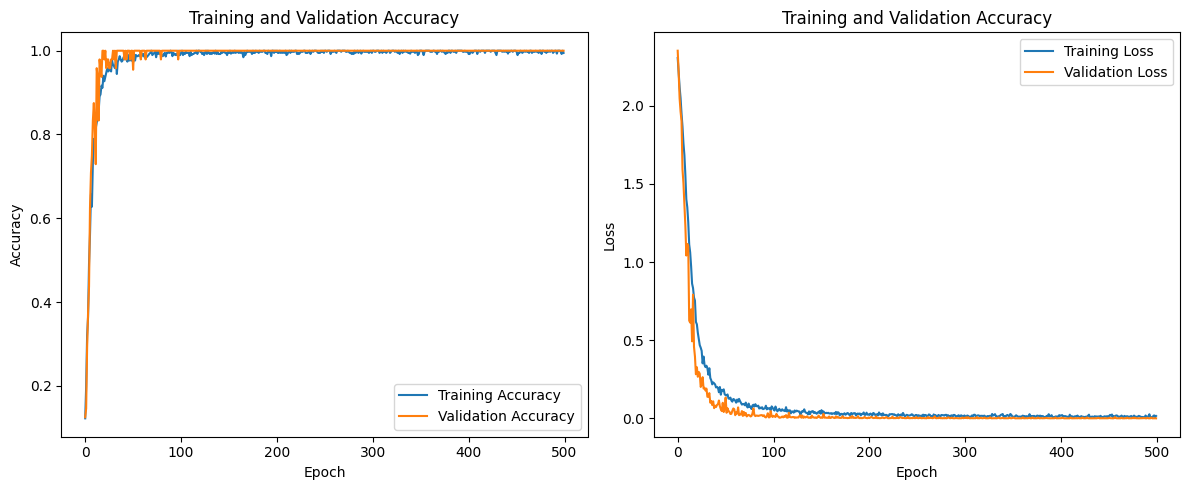

In [21]:
train_model(model, train_data, val_data)


# Test model

*   MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/model_20241111_123909.keras'

In [21]:
MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/model_20241111_123909.keras'

In [22]:
from tensorflow.keras.models import load_model

def test_model(model_path, data):
  # Load the saved model
  model = load_model(model_path)

  # Evaluate the model
  test_loss, test_accuracy = model.evaluate(data)
  print(f"Test Loss: {test_loss}")
  print(f"Test Accuracy: {test_accuracy}")

### Test with in-game images

In [23]:
test_model(MODEL_PATH, test_data)


49/49 ━━━━━━━━━━━━━━━━━━━━ 338s 7s/step - accuracy: 0.9795 - loss: 0.1513
Test Loss: 0.15415111184120178
Test Accuracy: 0.971794843673706


### Test with real-life images

In [29]:
real_life_test_dir = '/content/drive/MyDrive/Colab Notebooks/DatasetClassification/f1cars/test'

real_life_test_data = get_data_from_dir(real_life_test_dir)
real_life_test_data = real_life_test_data.prefetch(tf.data.AUTOTUNE)

test_model(MODEL_PATH, real_life_test_data)


Found 1462 files belonging to 10 classes.
92/92 ━━━━━━━━━━━━━━━━━━━━ 594s 6s/step - accuracy: 0.5648 - loss: 1.5372
Test Loss: 1.6090909242630005
Test Accuracy: 0.5512995719909668
